In [1]:
# Classification, Intrinsic dimension, Degeneracy
%run SetUp.ipynb
%run synthetic_datasets.ipynb

## Configuration 
Title = "Gen_Two" # general two layer
device = "cuda:0"
pt_option=True
width = 10
dataset = "Two circles" # Swiss / Two circles / Two moons / XOR
d = 2
n = 1000 # used number of data
num_classes = 2

### load_datasets ###
Epochs = 400*1000
trn_X, trn_Y = load_synthetic_dataset(dataset)

# create directory
output_path = f"./Results/{Title}"
create_directory(output_path)

Network Architecture

In [2]:
# general two-layer
class two_layer(nn.Module): # general two-layer
    def __init__(self, width, output_class=1, small_norm_init=True):
        super(two_layer, self).__init__()
        self.fc0 = nn.Linear(d, width)
        self.fc1 = nn.Linear(width, output_class, bias=False)
        self.width = width
        
        if small_norm_init:
            self.change_layer_weights(layer=0, W=0.1*torch.randn_like(self.W(0)), b=0.01*(self.b(0))) # multiply 0.01 
    
    def forward(self, x, restrict="None"):
        self.g1 = self.fc0(x)
        self.h1 = F.relu(self.g1)
        self.g2 = self.fc1(self.h1)
        
        if restrict == "positive":
            output = self.h1.matmul(self.fc1.weight.clamp(min=0).t()) # sum only positive, v_k >0  
        elif restrict == "negative":
            output = self.h1.matmul(self.fc1.weight.clamp(max=0).t()) # sum only negative, v_k <0
        elif restrict == "None":
            output =self.g2 ## the general output.
        else:
            raise ValueError(f"Please type the right restriction value, either 'positive' or 'negative'. The input was '{restrict}'.")
            
        return output #.clamp(min=-1, max=1)
    
    def count_weight_sign(self):
        self.positive_num = (self.W(1)>0).sum().item() 
        self.negative_num = (self.W(1)<0).sum().item() 
    
    def W(self, i):
        if i==0:
            output = self.fc0.weight
        elif i==1:
            output = self.fc1.weight
        return output
    def b(self, i):
        if i==0:
            output = self.fc0.bias
        elif i==1:
            output = self.fc1.bias
        return output
    
    def activation_pattern(self, x):
        self.forward(x)
        return (self.h1>0).float()
    
    def change_layer_weights(self, layer, W, b):
        if W.shape == self.W(layer).shape and b.shape == self.b(layer).shape:
            if layer ==0:
                self.fc0.weight = nn.Parameter(W)
                self.fc0.bias = nn.Parameter(b)
            elif layer ==1:
                self.fc1.weight = nn.Parameter(W)
                self.fc1.bias = nn.Parameter(b)
        else:
            raise ValueError("wrong shape of input tensors")
    
    def partition(self, w=1.6, title="img"):
        N = 200
        x,y = torch.meshgrid(torch.linspace(-w,w,N), torch.linspace(-w,w,N))
        grid = torch.stack((x,y),dim=2).to(device).float() # SHAPE 10,10,2
        self.count_weight_sign()
        
        fig, axs = plt.subplots(1,4, figsize=(16,4))
        
        
        rank = (net(grid.view(-1,2))<0.001).float().view(N,N)                     # decision boundary, output<0
        img0 = axs[0].contourf(x,y,rank.cpu(), np.arange(-1,2,1), cmap='gray')
        fig.colorbar(img0, ax=axs[0])
        axs[0].set_title("Decision boundary (DB)")
        
        ### total net
        rank = net(grid.view(-1,2)).view(N,N).detach().cpu()
        img = axs[1].contourf(x,y,rank.cpu(), cmap='gray')
        fig.colorbar(img, ax=axs[1])
        axs[1].set_title("Logit output")
        black_patch = mpatches.Patch(color='black', label='DB')
        blue_patch = mpatches.Patch(color='blue', label=r'$v_k>0$')
        red_patch = mpatches.Patch(color='red', label=r'$v_k<0$')
        axs[1].legend(handles=[blue_patch, red_patch], loc="upper left")
        
        # ### polytope A1
        rank = (net.h1.matmul(net.fc1.weight.clamp(min=0).t())).view(N,N).detach().cpu() 
        img1 = axs[2].contourf(x,y,rank.cpu(), cmap='gray') 
        fig.colorbar(img1, ax=axs[2])
        axs[2].set_title(fr"ABs with $v_k>0$, width={net.positive_num}") 
        
        
        # ### polytope B1
        rank = (net.h1.matmul(net.fc1.weight.clamp(max=0).t())).view(N,N).detach().cpu() 
        img2 = axs[3].contourf(x,y,rank.cpu(), cmap='gray') 
        fig.colorbar(img2, ax=axs[3])
        axs[3].set_title(fr"ABs with $v_k<0$, width={net.negative_num}")
        
        for i in range(net.width):
            if net.W(1)[0][i] >0 :
                for j in (1,2):
                    axs[j].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='blue', linewidths=0.5)
            else:
                for j in (1,3):
                    axs[j].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='red', linewidths=0.5)


        # dataset
        for j in range(4):
            axs[j].scatter(trn_X[:int(n/2),0].cpu(),trn_X[:int(n/2),1].cpu(), marker='.')
            axs[j].scatter(trn_X[int(n/2):,0].cpu(),trn_X[int(n/2):,1].cpu(), marker='.')

        plt.suptitle(f"AB and DB width={net.width}={net.positive_num}+{net.negative_num}")
        plt.savefig(folder_name+f"/{title}.png")
        plt.close()

In [3]:
net = two_layer(width=width, small_norm_init=False).to(device)
# Optimization setting
lr = 0.0001
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0002)
folder_name = output_path + f'/runs/{dataset}/' + datetime.datetime.now().strftime("%B%d_%H_%M_%S") 
writer = SummaryWriter(folder_name)

In [4]:
# Training

grad_norm = 0
trn_loss_tr = np.empty(0)
test_loss_tr = np.empty(0)
trn_acc_tr = np.empty(0)
test_acc_tr = np.empty(0)


test_acc = 0
test_loss = torch.zeros(1)
print("Start Training")
time.sleep(1)

log_period = 1000
for epoch in range(Epochs) :
    loss = criterion(net(trn_X), trn_Y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    
    if epoch ==0 or epoch % 1000 == 999 : # perturb every 50000 steps
        trn_loss_tr = np.append(trn_loss_tr, loss.item())
        test_loss_tr = np.append(test_loss_tr, test_loss.item())
        
        trn_acc = ((net(trn_X)>0).float() == trn_Y).sum().item() / len(trn_Y) *100
        trn_acc_tr = np.append(trn_acc_tr, trn_acc)
        test_acc_tr = np.append(test_acc_tr, test_acc)
        writer.add_scalars("ReLU/Loss", {
            "Trn_Loss": loss.item(),
            "Test_Loss": test_loss.item(), }
                           , epoch+1)
        writer.add_scalars("ReLU/Accuracy", {
            "Trn_acc": trn_acc,
            "Test_acc": test_acc, }
                           , epoch+1)
        if pt_option :
            print(f"Epoch: {epoch+1 :>5} || TRN_loss: {loss.item() :.4f} || TEST_loss: {test_loss.item():.4f} || TRN_ACC: {trn_acc:.3f} || TEST_ACC: {test_acc:.3f}")
        torch.save(net.state_dict(), folder_name+f"/saved_net_width_{width}.pt") 
        net.partition(title=f"{epoch+1}")
time.sleep(1)
print("Finish Training")

Start Training
Epoch:     1 || TRN_loss: 0.7131 || TEST_loss: 0.0000 || TRN_ACC: 50.000 || TEST_ACC: 0.000


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch:  1000 || TRN_loss: 0.6745 || TEST_loss: 0.0000 || TRN_ACC: 84.100 || TEST_ACC: 0.000
Epoch:  2000 || TRN_loss: 0.6411 || TEST_loss: 0.0000 || TRN_ACC: 81.900 || TEST_ACC: 0.000
Epoch:  3000 || TRN_loss: 0.6077 || TEST_loss: 0.0000 || TRN_ACC: 88.800 || TEST_ACC: 0.000
Epoch:  4000 || TRN_loss: 0.5691 || TEST_loss: 0.0000 || TRN_ACC: 91.200 || TEST_ACC: 0.000
Epoch:  5000 || TRN_loss: 0.5260 || TEST_loss: 0.0000 || TRN_ACC: 91.200 || TEST_ACC: 0.000
Epoch:  6000 || TRN_loss: 0.4817 || TEST_loss: 0.0000 || TRN_ACC: 91.000 || TEST_ACC: 0.000
Epoch:  7000 || TRN_loss: 0.4400 || TEST_loss: 0.0000 || TRN_ACC: 90.400 || TEST_ACC: 0.000
Epoch:  8000 || TRN_loss: 0.4011 || TEST_loss: 0.0000 || TRN_ACC: 90.200 || TEST_ACC: 0.000
Epoch:  9000 || TRN_loss: 0.3655 || TEST_loss: 0.0000 || TRN_ACC: 90.400 || TEST_ACC: 0.000
Epoch: 10000 || TRN_loss: 0.3321 || TEST_loss: 0.0000 || TRN_ACC: 90.700 || TEST_ACC: 0.000
Epoch: 11000 || TRN_loss: 0.2996 || TEST_loss: 0.0000 || TRN_ACC: 91.600 || TEST

KeyboardInterrupt: 

In [5]:
print(f"ACC {((net(trn_X)>0).float().squeeze() == (trn_Y==1).float().squeeze()).sum().item() / len(trn_Y) * 100} %")

ACC 100.0 %


Finding Polytope-basis cover induced from the trained two-layer

In [6]:
# TO find a compressed polytope cover ?
polytope_cover_by_th = [] # the list of polytopes, defined by the threshold values.
degree_acc = 0

# find polytope cover
while degree_acc < trn_acc_tr[-1] - 0.001 :
    positive_degree = torch.zeros(len(trn_X))
    negative_degree =  torch.zeros(len(trn_X))
    for th in polytope_cover_by_th:
        positive_degree += (net(trn_X, restrict="positive") < th).float().squeeze().cpu() ## a data is contained in this positive polytope.
        negative_degree += (net(trn_X, restrict="negative") > -th).float().squeeze().cpu() ## a data is contained in this negative polytope.
    output_degree = - positive_degree + negative_degree
    degree_acc = ((output_degree>0).float() == trn_Y.squeeze().cpu()).sum().item() / len(output_degree) * 100
    
    # pick a wrong data point.
    wrong_data_index = ((output_degree.to(device)<=0).float().squeeze() != (net(trn_X)<0).squeeze())  ### 왜 버그 ?
    if wrong_data_index.sum().item() == 0 : # there is no wrong data. 
        print("Perfectly matched with the given network") # Finally, we get the perfect polytope-basis cover !
        break
    else: # otherwise, we still add a convering polytope in our polytope-basis cover.
        wrong_data = trn_X[wrong_data_index]
        ### th 중 가장 data가 많이 커버될 수 있는 그런거..!를 찾자.
        polytope_variance = net(wrong_data, restrict="positive") + net(wrong_data, restrict="negative")
        argmax_index = polytope_variance.abs().argmin() # max ? min ? // 최소 polytope 을 어떻게 구할 수 있을까.
#         argmax_index = torch.randint(wrong_data_index.sum().long().item(), (1,)) ## random index ## empicially similar performance !

        new_th = (net(wrong_data[argmax_index], restrict="positive") - net(wrong_data[argmax_index], restrict="negative")  ).item()/2
                        # Here, then the wrong_data is not covered in "positive", while covered by "negative"
        
        # add a new polytope th to the cover list
        print(f"Accuracy = {degree_acc :.2f}% The new thershold {new_th:.2f} has been added to the polytope cover list.")
        polytope_cover_by_th.append(new_th)

        
print(f"\nCompleted. We achieved a polytope-basis cover consists of 2*{len(polytope_cover_by_th)}={2*len(polytope_cover_by_th)} polytopes.")
print(f"Trained neural network acc : {trn_acc_tr[-1] :.2f} %")


# ACC of the cover.
positive_degree = torch.zeros(len(trn_X))
negative_degree =  torch.zeros(len(trn_X))
for th in polytope_cover_by_th:
    positive_degree += (net(trn_X, restrict="positive") < th).float().squeeze().cpu() ## a data is contained in this positive polytope.
    negative_degree += (net(trn_X, restrict="negative") > -th).float().squeeze().cpu() ## a data is contained in this negative polytope.
output_degree = - positive_degree + negative_degree
degree_acc = ((output_degree>0).float() == trn_Y.squeeze().cpu()).sum().item() / len(output_degree) * 100
print(f"The polytope-basis cover accuracy = {degree_acc :.2f}%")

Accuracy = 50.00% The new thershold 12.58 has been added to the polytope cover list.
Perfectly matched with the given network

Completed. We achieved a polytope-basis cover consists of 2*1=2 polytopes.
Trained neural network acc : 100.00 %
The polytope-basis cover accuracy = 100.00%


In [7]:
# Save the figures :: 2 x 2
N = 200
w=1.6
x,y = torch.meshgrid(torch.linspace(-w,w,N), torch.linspace(-w,w,N))
grid = torch.stack((x,y),dim=2).to(device).float() # SHAPE 10,10,2
net.count_weight_sign()


# for th in np.linspace(16, 80, 80-16+1):
# for th in (35.92,):
for index, th in enumerate(polytope_cover_by_th): ### visualize the obtained polytope-basis cover.
    fig, axs = plt.subplots(2,2, figsize=(10,8))

    rank = (net(grid.view(-1,2))<0.001).float().view(N,N)                     # decision boundary, output<0
    img0 = axs[0][0].contourf(x,y,rank.cpu(), np.arange(-1,2,1), cmap='gray')
    fig.colorbar(img0, ax=axs[0][0])
    axs[0][0].set_title("Decision boundary (DB)")

    ### total net
    rank = net(grid.view(-1,2)).view(N,N).detach().cpu()
    img = axs[0][1].contourf(x,y,rank.cpu(), cmap='gray')
    fig.colorbar(img, ax=axs[0][1])
    axs[0][1].set_title("Logit output")
    black_patch = mpatches.Patch(color='black', label='DB')
    blue_patch = mpatches.Patch(color='blue', label=r'$v_k>0$')
    red_patch = mpatches.Patch(color='red', label=r'$v_k<0$')
    axs[0][1].legend(handles=[blue_patch, red_patch])

    # ### polytope +
    rank = (net.h1.matmul(net.fc1.weight.clamp(min=0).t())).view(N,N).detach().cpu() 
    img1 = axs[1][0].contourf(x,y, (rank<th).float().cpu(), np.arange(-1,2,1), cmap='gray') 
    fig.colorbar(img1, ax=axs[1][0])
    axs[1][0].set_title(r"Polytope : $\mathcal{T}_+(x)$"+f"$<{th :.2f}$") 

    # ### polytope -
    rank = (net.h1.matmul(net.fc1.weight.clamp(max=0).t())).view(N,N).detach().cpu() 
    img2 = axs[1][1].contourf(x,y, (rank>-th).float().cpu(), np.arange(-1,2,1), cmap='gray') 
    fig.colorbar(img2, ax=axs[1][1])
    axs[1][1].set_title(r"Polytope : $\mathcal{T}_-(x)$"+f"$>-{th :.2f}$") 

    for i in range(net.width):
        if net.W(1)[0][i] >0 :
            axs[0][1].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='blue', linewidths=0.5)
            axs[1][0].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='blue', linewidths=0.5)
        else:
            axs[0][1].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='red', linewidths=0.5)
            axs[1][1].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='red', linewidths=0.5)

    # dataset
    for i in range(2):
        for j in range(2):
            axs[i][j].scatter(trn_X[:int(n/2),0].cpu(),trn_X[:int(n/2),1].cpu(), marker='.')
            axs[i][j].scatter(trn_X[int(n/2):,0].cpu(),trn_X[int(n/2):,1].cpu(), marker='.')
    #     axs[j].scatter(X[:,0].cpu(), X[:,1].cpu(), marker='*', s=200, color="darkgreen") # special input

    plt.suptitle(f"AB and DB width={net.width}={net.positive_num}+{net.negative_num}")
    plt.savefig(folder_name+f"/cover{int(index+1)}.png")
    # plt.show()
    plt.close()

In [8]:
# Save the figures :: 2 x 2
N = 200
w=1.6
x,y = torch.meshgrid(torch.linspace(-w,w,N), torch.linspace(-w,w,N))
grid = torch.stack((x,y),dim=2).to(device).float() # SHAPE 10,10,2
net.count_weight_sign()


fig, axs = plt.subplots(2,1, figsize=(5,7), squeeze=False)
rank = (net(grid.view(-1,2))<0.001).float().view(N,N)                     # decision boundary, output<0
img0 = axs[0][0].contourf(x,y,rank.cpu(), np.arange(-1,2,1), cmap='gray')
fig.colorbar(img0, ax=axs[0][0])
axs[0][0].set_title("Decision boundary (DB)")

### total net
rank = net(grid.view(-1,2)).view(N,N).detach().cpu()
img = axs[1][0].contourf(x,y,rank.cpu(), cmap='gray')
fig.colorbar(img, ax=axs[1][0])
axs[1][0].set_title("Logit output")
black_patch = mpatches.Patch(color='black', label='DB')
blue_patch = mpatches.Patch(color='blue', label=r'$v_k>0$')
red_patch = mpatches.Patch(color='red', label=r'$v_k<0$')
axs[1][0].legend(handles=[blue_patch, red_patch])
for i in range(net.width):
    if net.W(1)[0][i] >0 :
        axs[1][0].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='blue', linewidths=0.5)
    else:
        axs[1][0].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='red', linewidths=0.5)
# dataset
for i in range(2):
    axs[i][0].scatter(trn_X[:int(n/2),0].cpu(),trn_X[:int(n/2),1].cpu(), marker='.')
    axs[i][0].scatter(trn_X[int(n/2):,0].cpu(),trn_X[int(n/2):,1].cpu(), marker='.')
plt.suptitle(f"AB and DB width={net.width}={net.positive_num}+{net.negative_num}")
plt.savefig(folder_name+f"/figure.png")
plt.close()
    
for index, th in enumerate(polytope_cover_by_th): ### visualize the obtained polytope-basis cover.
    fig, axs = plt.subplots(2,1, figsize=(5,7), squeeze=False)
    # ### polytope +
    rank = (net.h1.matmul(net.fc1.weight.clamp(min=0).t())).view(N,N).detach().cpu() 
    img1 = axs[0][0].contourf(x,y, (rank<th).float().cpu(), np.arange(-1,2,1), cmap='gray') 
    fig.colorbar(img1, ax=axs[0][0])
    axs[0][0].set_title(r"Polytope : $\mathcal{T}_+(x)$"+f"$<{th :.2f}$") 

    # ### polytope -
    rank = (net.h1.matmul(net.fc1.weight.clamp(max=0).t())).view(N,N).detach().cpu() 
    img2 = axs[1][0].contourf(x,y, (rank>-th).float().cpu(), np.arange(-1,2,1), cmap='gray') 
    fig.colorbar(img2, ax=axs[1][0])
    axs[1][0].set_title(r"Polytope : $\mathcal{T}_-(x)$"+f"$>-{th :.2f}$") 

    for i in range(net.width):
        if net.W(1)[0][i] >0 :
            axs[0][0].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='blue', linewidths=0.5)
        else:
            axs[1][0].contour(x,y, (net.h1[:,i]>0).float().cpu().view(N,N), levels=1, colors='red', linewidths=0.5)
    # dataset
    for i in range(2):
        axs[i][0].scatter(trn_X[:int(n/2),0].cpu(),trn_X[:int(n/2),1].cpu(), marker='.')
        axs[i][0].scatter(trn_X[int(n/2):,0].cpu(),trn_X[int(n/2):,1].cpu(), marker='.')

    plt.suptitle(f"AB and DB width={net.width}={net.positive_num}+{net.negative_num}")
    plt.savefig(folder_name+f"/separate{int(index+1)}.png")
    # plt.show()
    plt.close()

The result of training

In [9]:
trn_X_activation_pattern = net.activation_pattern(trn_X).cpu().long()
counts = {}
for binary_code in trn_X_activation_pattern:
    if str(binary_code) in counts:
        counts[str(binary_code)] += 1
    else:
        counts[str(binary_code)] = 1

print(f"There are totally {len(counts)} activation patterns among {len(trn_X)} data points")


There are totally 12 activation patterns among 1000 data points


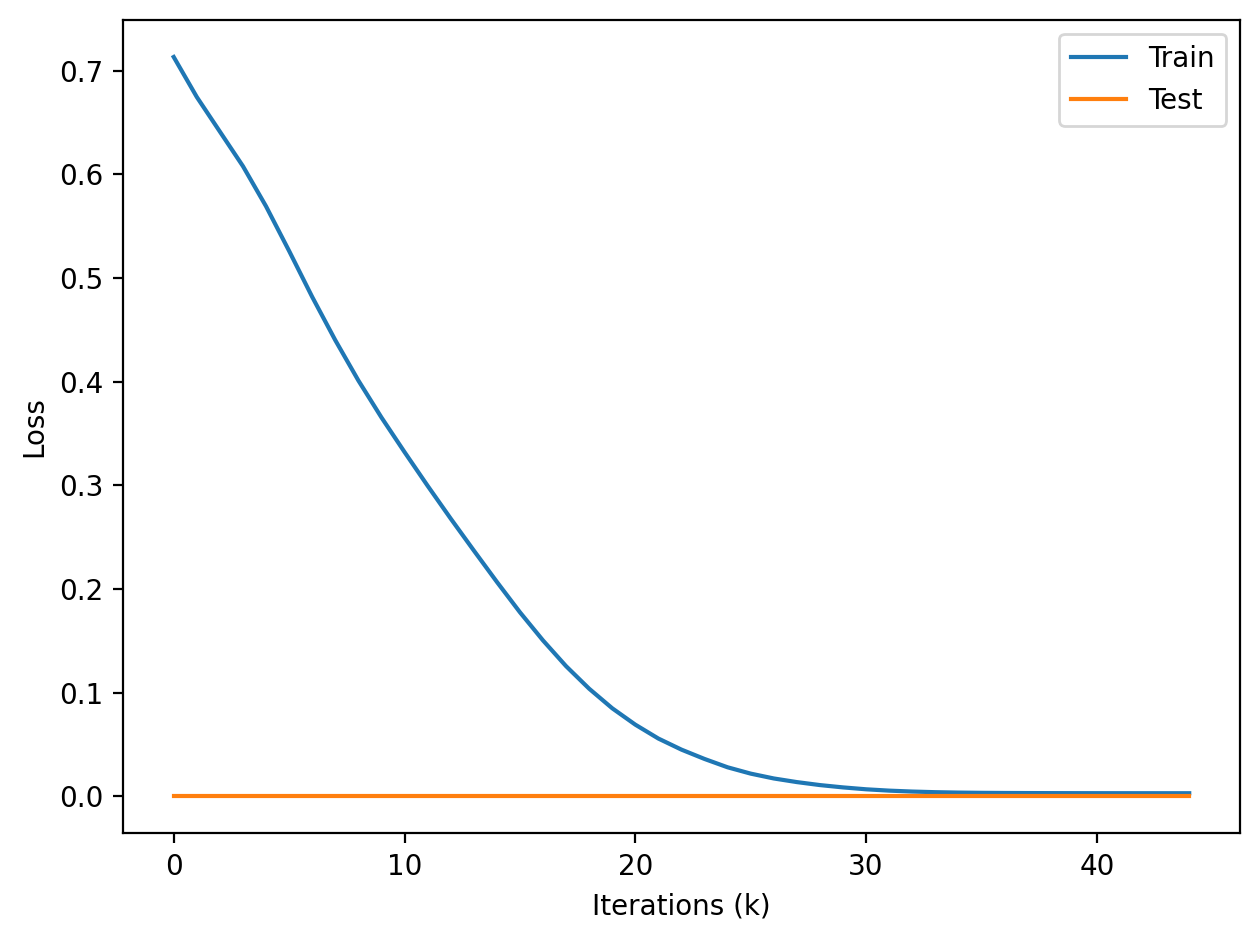

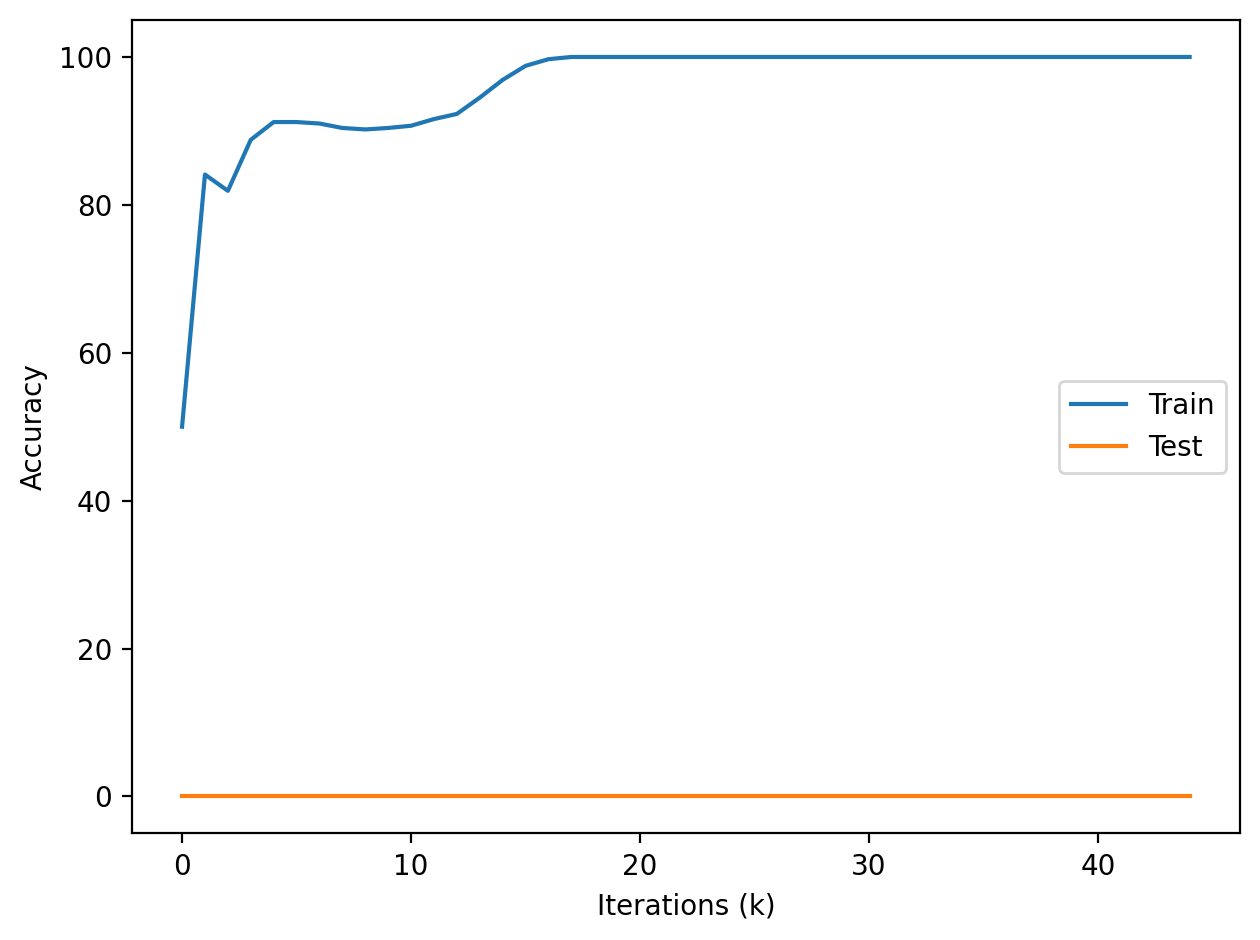

In [10]:
# PLOT THE LOSS GRAPH
plt.plot(trn_loss_tr, label="Train")
plt.plot(test_loss_tr, label="Test")
plt.xlabel("Iterations (k)")
plt.ylabel("Loss")
# plt.yscale("log")
plt.legend()
plt.savefig(folder_name+"/loss_fig_fullview.png")
plt.show() 

# PLOT THE ACCURACY GRAPH
plt.plot(trn_acc_tr, label="Train")
plt.plot(test_acc_tr, label="Test")
plt.xlabel("Iterations (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(folder_name+"/Accuracy.png")
plt.show()

In [11]:
# Save result txt file.
f = open(f"./{folder_name}/result.txt", 'w')
f.write(
f"""
    This is a CFG file.
    
    # Accuracy
    Trn_acc : {trn_acc_tr[-1] :.3f}
    Test_acc : {test_acc_tr[-1] :.3f}
    
    # Loss
    Trn_loss : {loss.item() :.4f} 
    Test_loss : {test_loss.item() :.4f} 
    
    
    # dataset
    dataset = {dataset}
    n = {n} # number of data
    d = {d} # dimension
    num_class = {num_classes} # the class, used in this binary classification
    width = f{width}
    # Network
    {net}
    
    ## polytopes
    # of distinct activation patterns = {len(counts)}
    dictionary values (duplication) = {counts.values()}
    
    # optimization
    Epochs = {Epochs}
    lr = {lr}
    optimizer = {optimizer}
    Last epoch = {epoch+1}
"""
)
f.close()